# Tercer experimento
En este experimento quise aplicar el Tf-idf y seccionar la palabras que van a ser relevantes para la descripción de las palabras.
En esta parte del proyecto ya no voy a conseguir de nuevo el corpus, el corpus debe estar en el archivo csv.
Con el siguiente código vamos a obtener los valores Tf-idf, usando la biblioteca sklearn.

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import csv
corpus={}
with open('datos.csv',"r",newline='') as csvfile:
	spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
	for row in spamreader:
		corpus[row[0]]=row[1]
vectorizador=TfidfVectorizer(smooth_idf=True,use_idf=True)
palabras=vectorizador.fit_transform(corpus.values())
feature_names=vectorizador.get_feature_names()

Luego con estas funciones vamos a conseguir la info que esta relacionada con el tf-idf

In [2]:
def getData(coo_matrix,feature_names):
    puntos=[]
    for score,idx in zip(coo_matrix.data,coo_matrix.col):
        puntos.append((feature_names[idx],score))
    puntos.sort(key=lambda x:x[1])
    return puntos
keywords=getData(palabras.tocoo(),feature_names)


Luego voy a graficar como estan distribuidas las palabras, se puede ver que aparece la distribución de Zipf.

In [3]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(range(len(keywords)),[x[1] for x in keywords], 'r,')
plt.axis([-10, len(keywords)*1.1, 0, 1])
plt.yscale('linear')
plt.grid(True)
plt.show()

<Figure size 640x480 with 1 Axes>

luego cortaré una parte de las palabras ya que los extremos son un poco discontinuos, esto por que quiero usar el criterio del codo(elbow) para discriminar las palabras relevantes de las que no. En el siguiente código voy a cortar el 20% de la parte inferior y el 5% de la parte superior y lo graficaré de nuevo.

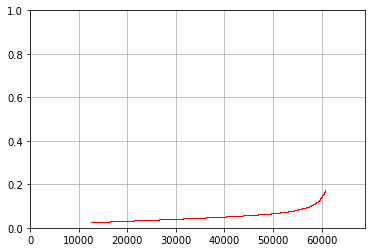

In [4]:
limInf=int(len(keywords)*0.2)
limSup=int(len(keywords)*0.97)
keywords2=keywords[limInf:limSup]
plt.plot(range(limInf,limInf+len(keywords2)),
    [x[1] for x in keywords2]
    , 'r,')
plt.axis([-10, len(keywords)*1.1, 0, 1])
plt.yscale('linear')
plt.grid(True)
plt.show()

Luego sobre este subconjunto usaré el criterio del codo, con la siguiente función.

In [ ]:
def getDiff(ant,act,sig):
    return ((sig[0]-act[0])*sig[1]+(act[0]-ant[0])*ant[1]-(sig[0]-act[0])*(act[0]-ant[0])*2*act[1])/((sig[0]-act[0])*(act[0]-ant[0])*(sig[0]-ant[0]))

def getElbow(puntos):
    # Regresa el indice donde esta en codo
    diferencias=[]
    ant=next(puntos)
    act=next(puntos)
    for sig in puntos:
        diferencias.append(getDiff(ant,act,sig))
        ant,act=act,sig
    tuplas=[(i,diferencias[i]) for i in range(len(diferencias))]
    tuplas.sort(key=lambda x: x[1])
    return tuplas[0]
codo=list(getElbow(zip(range(len(keywords2)),[x[1] for x in keywords2])))
codo[0]+=limInf
print(codo[0]-limInf)
print(len(keywords2))

47482
48248


Luego grafico la parte de las palabras que consideraré relevante. 

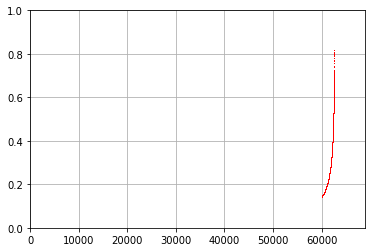

In [ ]:
plt.plot(range(codo[0],codo[0]+len(keywords[codo[0]:])),
    [x[1] for x in keywords[codo[0]:]]
    , 'r,')
plt.axis([-10, len(keywords)*1.1, 0, 1])
plt.yscale('linear')
plt.grid(True)
plt.show()

Por último se muestran las 10 palabras más relevantes del corpus

In [ ]:
for i in range(10):
    print(keywords[-i-1])

('malaria', 0.8142417850200112)
('níquel', 0.8033948847573729)
('tobillo', 0.7971971412306091)
('urticaria', 0.7943309678824464)
('peste', 0.7922154142527724)
('sarampión', 0.790719583585367)
('lepra', 0.7896523777863795)
('enuresis', 0.789555333595977)
('ganglión', 0.7883428779978374)
('tuberculosis', 0.7832898984179828)


Ya al final estas palabras estarán guardadas en la variable keywords.

In [ ]:
ignoradas=keywords[:codo[0]]
keywords=keywords[codo[0]:]

Ahora voy a sacar vectores de los vectores que describen las palabras relevantes para nuestro corpus, con el siguiente código cargamos el set de vectores:

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
wordvectors_file_vec = 'fasttext-sbwc.3.6.e20.vec.gz'
cantidad = 100000
num_features=300
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)

Con el siguiente código se va a convertir a vectores:

In [ ]:
def VectorSimilar(palabras):
    global wordvectors
    global ignoradas
    acum=np.zeros(300)
    for p in palabras:
        if p not in ignoradas:
            try:
                acum=np.add(acum,wordvectors[p])
            except:
                palabraAux=input("No conozco "+str(p)+", dime a que otra palabra se parece: ")
                acum=np.add(acum,VectorSimilar(palabraAux.split()))
    aux=np.add(acum,np.random.rand(300))
    print(aux)
    return aux


vectores=[]
for i in keywords:
    try:
        vectores.append(wordvectors[i[0]])
    except:
        palabraAux=input("No conozco "+str(i[0])+", dime a que otra palabra se parece: ")
        vectores.append(VectorSimilar(palabraAux.split()))

No conozco neumococos, dime a que otra palabra se parece: bacteria infección neumonía
No conozco descamativa, dime a que otra palabra se parece: escascaramiento capas piel
No conozco escascaramiento, dime a que otra palabra se parece: desprendimiento
No conozco angioedema, dime a que otra palabra se parece: edema
No conozco pertussis, dime a que otra palabra se parece: tosferina
No conozco tosferina, dime a que otra palabra se parece: resfriado tos leve fiebre apnea vómito agotamiento vacuna
No conozco reumáticas, dime a que otra palabra se parece: reumatica
No conozco reumatica, dime a que otra palabra se parece: reumática
No conozco actínicas, dime a que otra palabra se parece: precancer de la piel 
No conozco precancer, dime a que otra palabra se parece: previo cancer


In [ ]:
print(vectores)

# Interrupción del experimento 3
Como se vio el experimento 3, trataba de solucionar las palabras que los embeddings desconocian, sin embargo para esto debia de introducir manualmente, puede ser por un documento, las palabras que están relacionadas con esta palabra en lugar de hacer esto automáticamente como se hace en los siguientes experimentos, esto tiene la desventaja que las palabras dependerán estáticamente de las otras palabras que según mi parecer describan esa palabra por esta razón aunque una palabra sea más importante en la descripción, el vector se inclinará por irse a la mitad.